# Analysis of SleepCycle(TM) data

Let's start by enabling the display of *multiple* outputs from singel cells:

In [142]:
# Allow multiple outputs in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

We will also enable reloading of python modules when they are edited. This way we can change code in the ``quelf`` module, and see the changed behaviour without restarting the notebook:

In [143]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will download the data which is available from the "export" button on SleepSecure(TM). This might take a while the first time, as the data is downloaded from a *relatively* slow server:

In [144]:
from quelf.sleepcycle import SleepCycle

sc = SleepCycle()
data = sc.data

How many "sleep sessions" have we in our dataset?

In [145]:
len(data)

820

What columns (fields) does our data consist of?

In [146]:
data.columns

Index(['events', 'start', 'stop'], dtype='object')

What does our most recent data point look like?

In [147]:
data.loc[0]

events    [[60.0, 3, 0.11230000000000001], [60.0, 1, 0.0...
start                                   2018-03-31 01:09:58
stop                                    2018-03-31 09:03:21
Name: 0, dtype: object

## Data processing
Now we have the raw data, but we should process it a little before analyzing it. Let's calculate how long each sleep session lasts:

In [148]:
time_slept = data['stop'] - data['start']
data['time_slept'] = time_slept
time_slept.describe()

count                       820
mean     0 days 08:48:10.129268
std      0 days 01:22:09.785122
min             0 days 01:09:58
25%      0 days 08:06:46.750000
50%      0 days 08:36:09.500000
75%      0 days 09:25:50.750000
max             0 days 14:20:10
dtype: object

#### Outlier detection
The dataset might contain some outliers. We will print the rows with the most extreme sleep durations. If these maximum and/or minimum values look incorrect to you, you might want to delete the datapoints from the SleepCycle app, delete the contents of the ``./data`` sub-directory, and rerun this notebook.

In [149]:
# Show the maximum and minimum time slept, and on which date they occur
data[data['time_slept'] == data['time_slept'].max()]
data[data['time_slept'] == data['time_slept'].min()]

,events,start,stop,time_slept
178,"[[60.0, 3, 0.3593], [60.0, 1, 0.53549999999999...",2017-09-30 01:42:30,2017-09-30 16:02:40,14:20:10


,events,start,stop,time_slept
86,"[[60.0, 1, 0.062399999999999005], [60.0, 3, 0....",2018-01-07 03:14:30,2018-01-07 04:24:28,01:09:58


Set ``MAX_HOURS`` and ``MIN_HOURS`` to a value which could indicate something being wrongly recorded into SleepCycle. Delete unwanted sleep sessions from the sleep cycle app.

In [150]:
MAX_HOURS = 13
MIN_HOURS = 4

data[data['time_slept'].dt.total_seconds() > MAX_HOURS*60*60]
data[data['time_slept'].dt.total_seconds() < MIN_HOURS*60*60]

,events,start,stop,time_slept
178,"[[60.0, 3, 0.3593], [60.0, 1, 0.53549999999999...",2017-09-30 01:42:30,2017-09-30 16:02:40,14:20:10
291,"[[60.0, 1, 0.0454], [60.0, 3, 0.0086], [120.0,...",2017-06-03 00:22:45,2017-06-03 13:32:00,13:09:15
353,"[[60.0, 1, 0.047399999999999005], [60.0, 3, 0....",2017-04-01 01:11:42,2017-04-01 14:44:52,13:33:10
442,"[[60.0, 3, 0.0018000000000000002], [60.0, 1, 0...",2017-01-03 01:25:44,2017-01-03 14:30:02,13:04:18
571,"[[60.0, 3, 0.010400000000000001], [60.0, 1, 0....",2016-08-26 00:50:44,2016-08-26 15:03:34,14:12:50
788,"[[60.0, 1, 0.06419999999999901], [120.0, 1, 0....",2016-01-14 21:43:36,2016-01-15 11:27:13,13:43:37


,events,start,stop,time_slept
66,"[[60.0, 1, 0.057799999999999005], [60.0, 3, 0....",2018-01-25 01:13:29,2018-01-25 04:13:31,03:00:02
67,"[[60.0, 3, 0.003899999999999], [60.0, 1, 0.054...",2018-01-24 22:49:56,2018-01-25 01:06:58,02:17:02
86,"[[60.0, 1, 0.062399999999999005], [60.0, 3, 0....",2018-01-07 03:14:30,2018-01-07 04:24:28,01:09:58
339,"[[60.0, 1, 0.068], [60.0, 3, 0.0178], [120.0, ...",2017-04-15 01:03:35,2017-04-15 02:22:44,01:19:09
372,"[[60.0, 1, 0.053199999999999005], [60.0, 3, 0....",2017-03-13 00:02:41,2017-03-13 02:51:53,02:49:12
410,"[[60.0, 3, 0.023699999999999003], [60.0, 1, 0....",2017-02-03 22:58:28,2017-02-04 01:37:04,02:38:36


## Plotting
Now that we have processed the data, we will try to plot sleep sessions bar plots as function of time.
The height should be relative to the sleep *duration*, and the bottom of each bar should show *when* you went to bed.
Finally, we can color each bar relative to how *long* each sleep session lasted.
This should result in a plot which can show sleep trends over time.

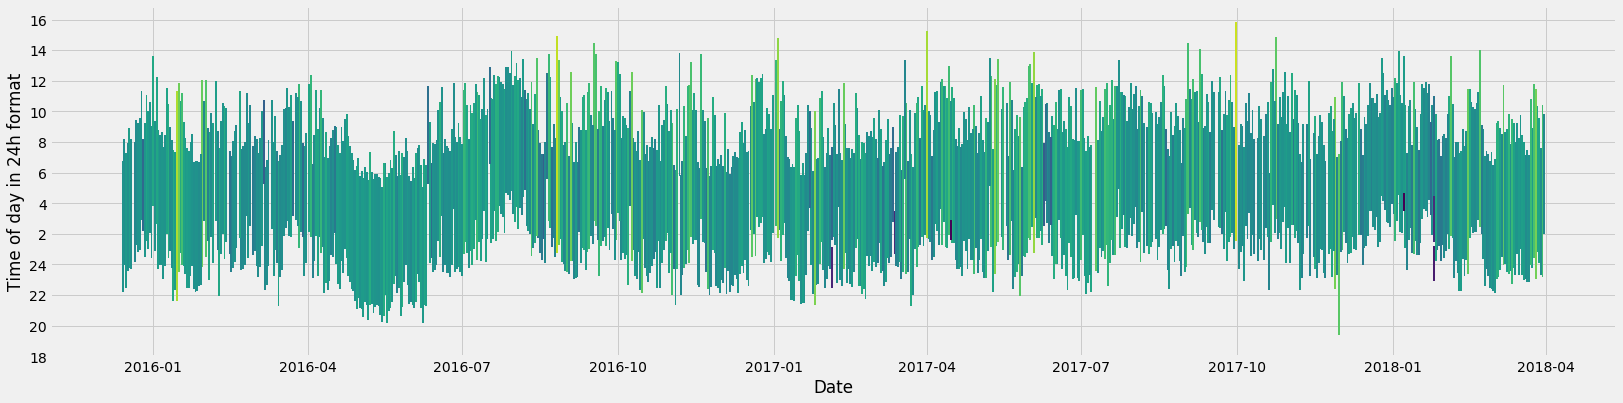

In [151]:
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Fill the width of a 1920x1080 screen when plotting the entire dataset
plt.rcParams['figure.figsize'] = [25, 6]

# Use FiveThirtyEight matplotlib theme
plt.style.use('fivethirtyeight')

# Calculate time went to bed, as a offset relative to 18:00
went_to_bed = (data['start'].dt.hour + (data['start'].dt.second / 60) - 18) % 24

# Decimal hours slept
hours_slept = time_slept.dt.total_seconds() / (60 * 60)

# Create colormap relative to hours slept
norm = (hours_slept - hours_slept.min()) / hours_slept.max()
cmap = cm.get_cmap()
color_map = cmap(norm)

# Bottom of barplot relative to 18:00, height relative to hours slept
ax = plt.bar(data['start'].values, hours_slept, bottom=went_to_bed, width=1.125, color=color_map)

xlabel = plt.xlabel('Date')
ylabel = plt.ylabel('Time of day in 24h format')

# Map ticks relative to 18:00
yticks = plt.yticks((np.arange(2, 25, 2) - 18) % 24, (np.arange(2, 25, 2)))

plt.show()

## SleepSecure(TM) API exploration
SleepCycle allows you to track much more than just sleep session, such as sleep quality, sleep notes, mood after waking up, and daily steps. SleepSecure offers some additional API endpoints. In particular, the ``/stat/session`` endpoint is of interest, as it offers much more fields related to each "sleep session". Here are all the available fields for each sleep session:

In [152]:
sc.fetch(endpoint='/stat/session', params={'id': '5718148320854016', 'next': '1'}).keys()

dict_keys(['rating', 'heartrate', 'graph_date', 'stop_tick_tz', 'start_tick_tz', 'window_offset_stop', 'stop_tick', 'start_global', 'id', 'window_start', 'window_offset_start', 'stop_global', 'stop_local', 'stats_version', 'sleep_notes', 'graph', 'stats_sq', 'seconds_from_gmt', 'alarm_mode', 'xaxis', 'graph_tib', 'start_tick', 'stats_wakeups', 'stats_duration', 'stats_sol', 'stats_mph', 'window_stop', 'state_mode', 'graph_inbed', 'steps', 'start_local'])

Since I have not found any endpoint which is able to dump *all* of the sleepsessions at once, we have to iterate over each sleep session and download the JSON seperately. In order to not pound the SleepSecure API with requests, the results are cached. This also saves quite some time, as updates are cheaper when you rerun this notebook after having logged new sleep sessions in the future. In order to clear the cache entirely, delete ``data/sleep_sessions.json``. The API rate delivers approximately 50 sleep sessions per minute.

Let's download all new data and cache it:

In [153]:
sc.update_sleep_sessions_cache()

We now have all the detailed data which SleepCycle records. All the numeric data can be summarized:

In [154]:
sc.sleep_sessions.describe()

,alarm_mode,id,rating,seconds_from_gmt,start_tick,state_mode,stats_duration,stats_mph,stats_sol,stats_sq,stats_version,stats_wakeups,stop_tick
count,823.000000,8.230000e+02,823.000000,823.000000,8.230000e+02,823.000000,823.000000,823.000000,823.0,823.000000,823.0,823.0,8.230000e+02
mean,0.758202,5.623340e+15,1.996355,5485.297691,5.081490e+08,1.997570,31680.189844,66.974574,0.0,0.856802,1.0,0.0,5.081807e+08
std,0.428433,6.480971e+14,0.867772,1799.071165,2.096072e+07,0.049266,4938.489546,28.442557,0.0,0.123959,0.0,0.0,2.096061e+07
min,0.000000,4.508087e+15,0.000000,3600.000000,4.717364e+08,1.000000,4197.997952,0.001000,0.0,0.115266,1.0,0.0,4.717671e+08
25%,1.000000,5.057569e+15,2.000000,3600.000000,4.901907e+08,2.000000,29182.881260,47.128088,0.0,0.794597,1.0,0.0,4.902236e+08
50%,1.000000,5.641216e+15,2.000000,7200.000000,5.079471e+08,2.000000,30970.711912,63.493928,0.0,0.874402,1.0,0.0,5.079787e+08
75%,1.000000,6.164741e+15,3.000000,7200.000000,5.261352e+08,2.000000,33951.261144,83.694092,0.0,0.952257,1.0,0.0,5.261663e+08
max,1.000000,6.754870e+15,3.000000,7200.000000,5.443979e+08,2.000000,51610.789962,216.629218,0.0,1.000000,1.0,0.0,5.444426e+08


Or, more specifically, a specific sleep session as an example which also shows non-numeric data:

In [155]:
sc.sleep_sessions.iloc[-4]

alarm_mode                                                             1
graph                  [[0, 93], [1, 70], [2, 42.963744904492344], [3...
graph_date                                        Friday 30-31 Mar, 2018
graph_inbed                                                01:09 - 09:03
graph_tib                                                           7:53
heartrate                                                            n/a
id                                                      5856529698521088
rating                                                                 2
seconds_from_gmt                                                    7200
sleep_notes                                    Drank coffee, Programming
start_global                                         2018-03-30T23:09:58
start_local                                          2018-03-31T01:09:58
start_tick                                                   5.44144e+08
start_tick_tz                                      

## Data processing
This data also requires some preprocessing before we are able to use it easily.
First, let's convert the daily step count from the strings ``x steps`` to the integers ``x``:

In [156]:
import re
steps_pattern = re.compile(r'(\d+) steps')
sc.sleep_sessions['step_count'] = sc.sleep_sessions['steps'].apply(lambda steps_string: int(steps_pattern.search(steps_string)[1]))

We should also specify that the column ``stats_duration`` indicates the number of seconds slept:

In [157]:
sc.sleep_sessions['stats_duration'] = sc.sleep_sessions['stats_duration'].astype('timedelta64[s]')

## Analysis
The DataFrame is now properly preprocessed for analysis.
We can begin by checking if there is any correlation between the daily step count, and the time slept that same day.

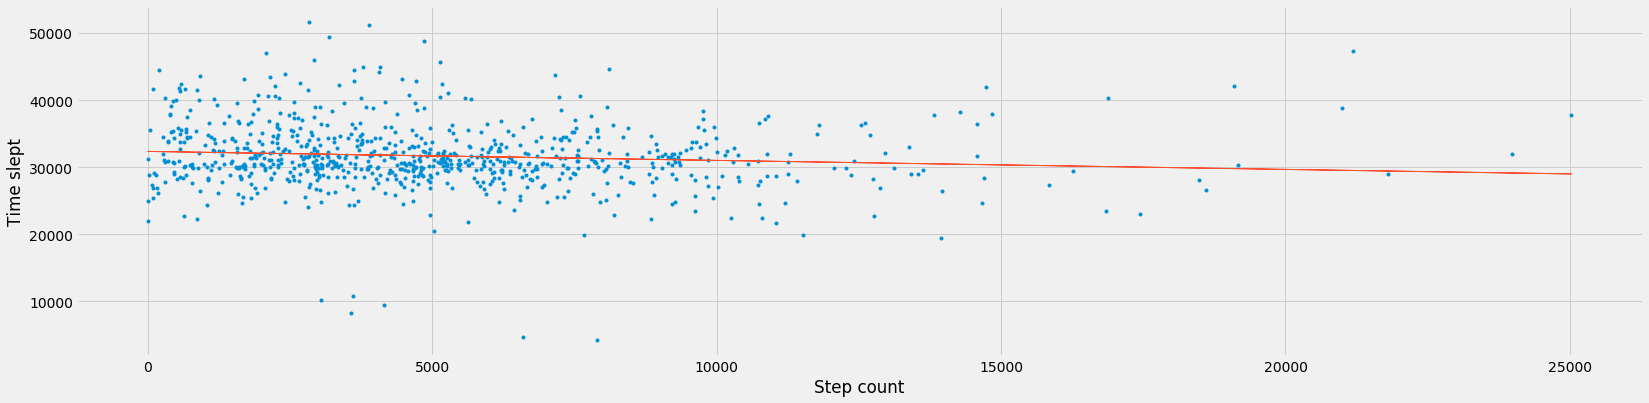

In [158]:
steps = sc.sleep_sessions['step_count']
seconds_slept = sc.sleep_sessions['stats_duration']

linfit = np.polyfit(steps, seconds_slept.astype('int'), 1)
linfit_func = np.poly1d(linfit)

scatter_plot = plt.plot(steps, seconds_slept, '.')
fit_plot = plt.plot(steps, linfit_func(steps), '-', linewidth=1)

xlab = plt.xlabel('Step count')
ylab = plt.ylabel('Time slept')

In [159]:
seconds_slept.astype('int').corr(steps)

-0.1000987884620032

In [160]:
linfit_func

poly1d([-1.34069592e-01,  3.23650547e+04])

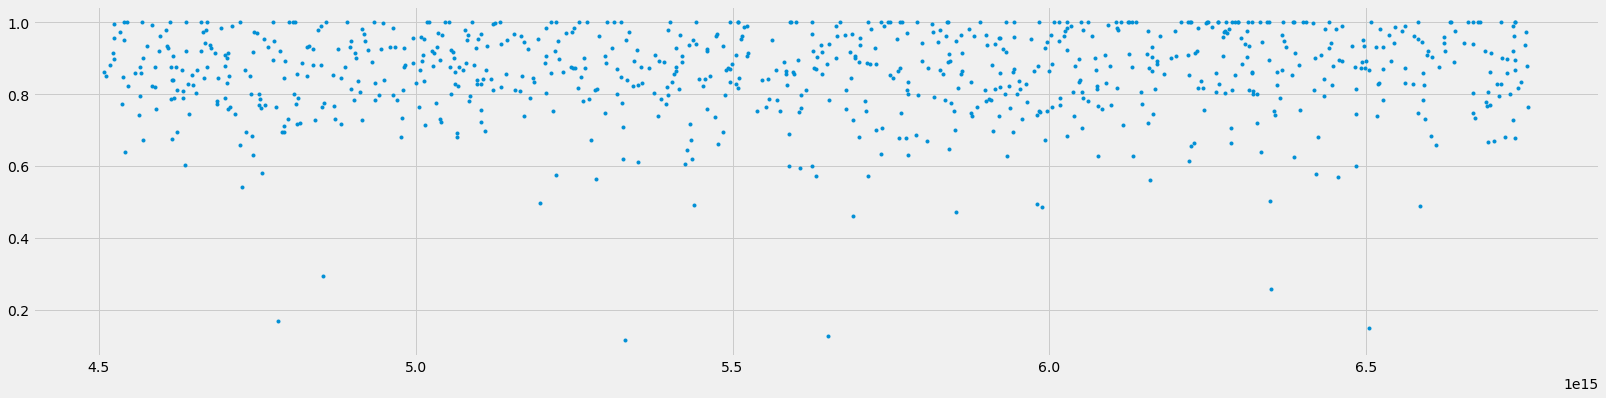

In [161]:
sleep_quality_plot = plt.plot(sc.sleep_sessions['id'], sc.sleep_sessions['stats_sq'], '.')